# Tutorial: Gaussians and Least Squares

So far in the notes and problems, we've mostly avoided one of the most commonly used probability distributions, the Gaussian or normal distribution:

$\mathrm{Normal}(x|\mu,\sigma) \equiv p_\mathrm{Normal}(x|\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma}}\exp \left[-\frac{(x-\mu)^2}{2\sigma^2}\right]$.[$^1$](#Note-1)

There are two reasons for this:
1. The symmetry between $x$ and $\mu$ makes it easy to miss the distinction between the sampling distribution and the likelihood function, and to conflate the model parameter $\sigma$ with an "error bar" associated strictly with the data (which it may or may not be).
2. The assumption of Gaussian PDFs is baked into various classical statistics methods to the extent that it isn't always obvious to the user. As always, it's important to think about whether an assumption or approximation is justified, and thus to see examples of when it is not.

That said, it is certainly common to use Gaussian distributions in practice, particularly in cases where
1. the approximation is well justified, as in the large-count limit of the Poisson distribution (typical of optical astronomy and longer wavelengths); or
2. we are effectively handed a table of data with "error bars" and have no better alternative than to assume a Gaussian sampling distribution.

Gaussians have lots of nice mathematical features that make them convenient to work with when we can. For example, see a list of identities for the multivariate Gaussian [here](https://cs.nyu.edu/~roweis/notes/gaussid.pdf) and a whole lot of math [here](http://www.lucamartino.altervista.org/2003-003.pdf).

There are a couple of cases that it's useful to work through if you haven't before, to build intuition. This is also good practice to reinforce some of the probability manipulations and reasoning you've learned.

We'll look at

* the product of two Gaussians
* conjugacy of Gaussians
* linear transformations of Gaussian-distributed variables
* classical weighted least squares and its Bayesian extension

In [1]:
TutorialName = 'gaussians'
exec(open('tbc.py').read()) # define TBC and TBC_above
import numpy as np
import scipy.stats as st
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Multiplication

The product of Gaussians comes up, for example, when the sampling distributions for different data points are independent Gaussians, or when the sampling distribution and prior are both Gaussian (this is a conjugate pair).

So, consider the product $\mathrm{Normal}(x|\mu_1,\sigma_1) \cdot \mathrm{Normal}(x|\mu_2,\sigma_2)$.

Show that this can be manipulated into a different product of two Gaussians,

$\mathrm{Normal}(x|\mu_1,\sigma_1) \, \mathrm{Normal}(x|\mu_2,\sigma_2) = \mathrm{Normal}(x|\mu_a,\sigma_a) \, \mathrm{Normal}(0|\mu_b,\sigma_b)$,

where

* $\mu_a = \sigma_a^{2}\left(\frac{\mu_1}{\sigma_1^2} + \frac{\mu_2}{\sigma_2^2}\right)$,
* $\sigma_a^2 = \left(\sigma_1^{-2} + \sigma_2^{-2}\right)^{-1}$,
* $\mu_b = \mu_1 - \mu_2$,
* $\sigma_b^2 = \sigma_1^2 + \sigma_2^2$.

If $x$ were a model parameter, and $\mu_i$ and $\sigma_i$ were independent measurements of $x$ with error bars, how do you interpret each term of this factorization?

Check your solution by plugging in some values for $x$, $\mu_i$ and $\sigma_i$. The cell below will then compare the log of both sides of the equation above. The exact value you get will depend on exactly what numbers you choose, but generally (**checkpoint**) it should be pretty small, say $<10^{-10}$ in absolute value.

* $\mu_a = \sigma_a^{2}\left(\frac{\mu_1}{\sigma_1^2} + \frac{\mu_2}{\sigma_2^2}\right)$,
* $\sigma_a^2 = \left(\sigma_1^{-2} + \sigma_2^{-2}\right)^{-1}$,
* $\mu_b = \mu_1 - \mu_2$,
* $\sigma_b^2 = \sigma_1^2 + \sigma_2^2$.

In [2]:
# pick some values (where m is mu, s sigma)
x = 2.0
m1 = 1.0
s1 = 0.1
m2 = 3.0
s2 = 0.2
# compute things
sa = 1/np.sqrt(1/s1**2+1/s2**2)
ma = sa**2*(m1/s1**2+m2/s2**2)
mb = m1-m2
sb = np.sqrt(s1**2+s2**2)

In [3]:
print('This should be a pretty small number:', 
      st.norm.logpdf(x,m1,s1) + st.norm.logpdf(x,m2,s2) - ( st.norm.logpdf(x,ma,sa) + st.norm.logpdf(0,mb,sb) ) )

This should be a pretty small number: -3.552713678800501e-14


For later, note that a multidimensional version of this identity also holds. Here $\Sigma$ is a covariance matrix, so we are missing some "squares" compared with the expressions above in terms of standard deviations (lower-case $\sigma$), but otherwise things are very similar.

$\mathrm{Normal}(x|\mu_1,\Sigma_1) \, \mathrm{Normal}(x|\mu_2,\Sigma_2) = \mathrm{Normal}(x|\mu_a,\Sigma_a) \, \mathrm{Normal}(0|\mu_b,\Sigma_b)$,

where

* $\mu_a = \Sigma_a\left(\Sigma_1^{-1}\mu_1 + \Sigma_2^{-1}\mu_2\right)$,
* $\Sigma_a = \left(\Sigma_1^{-1} + \Sigma_2^{-1}\right)^{-1}$,
* $\mu_b = \mu_1 - \mu_2$,
* $\Sigma_b = \Sigma_1 + \Sigma_2$.

## 2. Conjugacy

When the sampling distribution is normal with a fixed variance, the conjugate prior for the mean is also normal. Using the identity from part 1, show this for the case of a single data point, $y$; that is,

$p(\mu|y,\sigma) \propto \mathrm{Normal}(y|\mu,\sigma)\,\mathrm{Normal}(\mu|m_0,s_0) \propto \mathrm{Normal}(\mu|m_1,s_1)$,

$\exp(y-\mu)^2/\sigma^2\exp(\mu-m_0)^2/s_0^2 = \exp(2\mu^2-2\mu m_0/s_0^2-2\mu y/\sigma^2+y^2/\sigma^2+m_0^2/s_0^2)$
$=\exp((1/s_0^2+1/\sigma^2)(\mu^2-2\mu(m_0/s_0^2+y/\sigma^2)(1/(1/s_0^2+1/\sigma^2))+y^2/2\sigma^2+m_0^2/2s_0^2)$

and find $m_1$ and $s_1$ in terms of $y$, $\sigma$, $m_0$ and $s_0$.

$s_1=1/\sqrt(1/s_0^2+1/\sigma^2)$,

$m_1=(m_0/s_0^2+y/\sigma^2)s_1^2$

$\mathrm{Normal}(x|\mu_1,\sigma_1) \, \mathrm{Normal}(x|\mu_2,\sigma_2) = \mathrm{Normal}(x|\mu_a,\sigma_a) \, \mathrm{Normal}(0|\mu_b,\sigma_b)$,
* $\mu_a = \sigma_a^{2}\left(\frac{\mu_1}{\sigma_1^2} + \frac{\mu_2}{\sigma_2^2}\right)$,
* $\sigma_a^2 = \left(\sigma_1^{-2} + \sigma_2^{-2}\right)^{-1}$,
* $\mu_b = \mu_1 - \mu_2$,
* $\sigma_b^2 = \sigma_1^2 + \sigma_2^2$.

Again, check your work by choosing some fiducial values and 
using the cells below to look at the ratio

$\mathrm{Normal}(y|\mu,\sigma)\,\mathrm{Normal}(\mu|m_0,s_0) / \mathrm{Normal}(\mu|m_1,s_1)$

over a range of $\mu$. It should be constant.

In [4]:
# pick some values
y = 1.1
sigma = 0.15
m0 = 2.1
s0 = 0.4

# compute things
s1 = 1/np.sqrt(1/s0**2+1/sigma**2)
m1 = s1**2*(m0/s0**2+y/sigma**2)

This should be approximately constant:


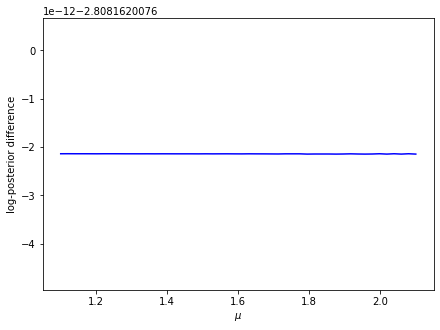

In [5]:
# plot over a range that at least includes both y and m0
mugrid = np.linspace(min(y,m0), max(y,m0))
# we'll compare the log-probabilities, since that's a good habit to be in
diff = st.norm.logpdf(y, loc=mugrid, scale=sigma)+st.norm.logpdf(mugrid, loc=m0, scale=s0) - st.norm.logpdf(mugrid, loc=m1, scale=s1)

print('This should be approximately constant:')
plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.plot(mugrid, diff, 'b-');
plt.xlabel(r'$\mu$');
plt.ylabel('log-posterior difference');

 **Checkpoint:** Remeber that in this case the plotted function should be close to _constant_, probably so close that matplotlib shows it as a perfectly flat line, but not necessarily small in absolute value.

## 3. Linear transformation

Consider the distribution $\mathrm{Normal}\left[y\,\big|\,\mu_y(x;a,b),\sigma_y\right]$, where $\mu_y(x;a,b)=a+bx$. 

Show that this can be rearranged into a Gaussian over $x$, i.e.

$\mathrm{Normal}\left[x|\mu_x(y;a,b),\sigma_x(y;a,b)\right]$,

up to an errant factor of $b$.

$\exp(y-a-bx)^2/\sigma_y^2 = \exp(y/b-a/b-x)^2/(\sigma_y/b)^2$

$\mu(y;a,b)=(y-a)/b$, $\sigma_x(y;a,b)=\sigma_y/b$

## 4. Classical weighted least squares (WLS)

Classical WLS is a simple method for fitting a line to data that you've almost certainly seen before. Consider data consisting of $n$ triplets $(x_i,y_i,\sigma_i)$, where $x_i$ are assumed to be known perfectly and $\sigma_i$ is interpreted as a "measurement error" for $y_i$. WLS maximizes the likelihood function

$\mathcal{L}(a,b;x,y,\sigma) = \prod_{i=1}^n \mathrm{Normal}(y_i|a+bx_i,\sigma_i)$.

In fact, we can get away with being more general and allowing for the possibility that the different measurements are not independent, with their measurement errors jointly characterized by a known covariance matrix, $\Sigma$, rather than the individual $\sigma_i$:

$\mathcal{L}(a,b;x,y,\Sigma) = \mathrm{Normal}(y|X\beta,\Sigma) = \frac{1}{\sqrt{(2\pi)^n|\Sigma|}}\exp \left[-\frac{1}{2}(y-X\beta)^\mathrm{T}\Sigma^{-1}(y-X\beta)\right]$,

where $X$ is called the _design matrix_, with each row equal to $(1, x_i)$, and $\beta = \left(\begin{array}{c}a\\b\end{array}\right)$.

With a certain amount of algebra, it can be shown that $\mathcal{L}$ is proportional to a bivariate Gaussian over $\beta$,

$\mathcal{L} \propto \mathrm{Normal}(\beta | \mu_\beta, \Sigma_\beta)$,

with

$\Sigma_\beta = (X^\mathrm{T}\Sigma^{-1}X)^{-1}$;

$\mu_\beta = \Sigma_\beta X^\mathrm{T}\Sigma^{-1} y$.

We will not drag you through the derivation, but hopefully the resemblance of these expressions to the simpler ones above makes them plausible.

In classical WLS, $\mu_\beta$ is the "best fit" estimate of $a$ and $b$, and $\Sigma_\beta$ is the covariance of the standard errors on those parameters.

The relative simplicity of the computations above, not to mention the fact that they are efficiently implemented in numerous packages, can be useful even in situations beyond the assumption-heavy scenario where WLS is derived. As a simple example, consider a case where the sampling distribution corresponds to the likelihood function above, but we wish to use an informative prior on $a$ and $b$.

Taking advantage of the results you derived above (all of which have straightforward multivariate analogs), 
1. What is the form of prior, $p(a,b|\alpha)$, that makes this problem conjugate? (Here $\alpha$ is a stand-in for whatever parameters determine the prior.)
2. What are the form and parameters of the posterior, $p(a,b|x,y,\Sigma,\alpha)$?
3. Verify that you recover the WLS solution in the limit of the prior being uniform over the $(a,b)$ plane.

In [ ]:
TBC() # answers in markdown

Below, we will explicitly show the correspondance in (3) for a WLS fit of some mock data.

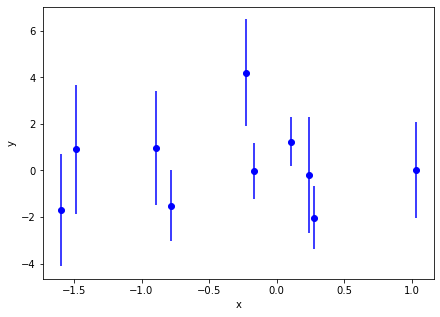

In [6]:
# generate some fake data
a = 0.0
b = 1.0
n = 10
x = st.norm.rvs(size=n)
sigma = st.uniform.rvs(1.0, 2.0, size=n)
y = st.norm.rvs(loc=a+b*x, scale=sigma, size=n)

plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.errorbar(x, y, yerr=sigma, fmt='bo');
plt.xlabel('x');
plt.ylabel('y');

The next cell uses the `statsmodels` package to perform the WLS calculations. You are encouraged to implement the matrix algebra above to verify the results. What we get at the end are $\mu_\beta$ and $\Sigma_\beta$, as defined above.

In [7]:
import statsmodels.api as sm

model = sm.WLS(y, sm.add_constant(x), weights=sigma**-2)
wls = model.fit()
mu_beta = np.matrix(wls.params).T # transpose casts this as a column vector
Sigma_beta = np.asmatrix(wls.normalized_cov_params)

In [8]:
mu_beta

matrix([[0.06382239],
        [0.23662103]])

In [9]:
Sigma_beta

matrix([[0.29283273, 0.11838848],
        [0.11838848, 0.72953275]])

Now, compute the parameters of the posterior for $\beta$ based on $\mu_\beta$ and $\Sigma_\beta$ (parameters that appear in the sampling distribution) and the parameters of the conjugate prior. Set the prior parameters to be equivalent to the uniform distribution for the check below (you can put in something different to see how it looks later).

Transform `post_mean` to a shape (2,) numpy array for convenience (as opposed to, say, a 2x1 matrix).

$s_1=1/\sqrt(1/s_0^2+1/\sigma^2)$,

$m_1=(m_0/s_0^2+y/\sigma^2)s_1^2$

In [61]:
# define prior parameters
a=st.uniform(loc=-5,scale=10).rvs()
b=st.uniform(loc=-5,scale=10).rvs()
# do some calculations, possibly
m_beta=np.array([[0],[0]])
s_beta=np.array([[10/np.sqrt(12),0],[0,10/np.sqrt(12)]])
# parameters of the posterior:
post_cov = np.linalg.inv(np.linalg.inv(Sigma_beta)+np.linalg.inv(s_beta))
post_mean = np.matmul(post_cov,np.matmul(Sigma_beta,mu_beta)+np.matmul(s_beta,m_beta)).reshape(2,1)

In [62]:
print('WLS mean and covariance:')
print(mu_beta)
print(Sigma_beta)

WLS mean and covariance:
[[0.06382239]
 [0.23662103]]
[[0.29283273 0.11838848]
 [0.11838848 0.72953275]]


In [63]:
print('Posterior mean and covariance:')
print(post_mean)
print(post_cov)

Posterior mean and covariance:
[[0.02774558]
 [0.10843416]]
[[0.26266484 0.08590631]
 [0.08590631 0.57954776]]


Add your log-prior to the function definition below. We will then compare your analytic solution to a brute-force calculation of the posterior.

In [64]:
def log_post_brute(a, b):
    like = np.sum( st.norm.logpdf(y, loc=a+b*x, scale=sigma) )
    prior = st.uniform.logpdf(a,loc=-5, scale=10)+st.uniform.logpdf(b,loc=-5, scale=10)
    return prior + like

In [65]:
post_mean=np.array(post_mean)
post_mean=post_mean.reshape(1,2)
post_mean=post_mean[0]

Difference between elegant and brute-force log posteriors for some random parameter values:
(The third column should be basically constant, though non-zero.)

[1.5834149173994838, -2.845254589304246, 21.925919418743717]
[2.56727599465803, -2.1240946407258745, 21.700754645685397]
[-0.297146968524701, -3.745380015035633, 21.520467398001585]
[2.372394580604067, -4.803574619651001, 19.007259982412606]
[-3.211866951265767, 4.702755346647685, 17.39220826885535]
[-2.768382807346602, -4.695735289465407, 19.055748944657505]
[1.0028011241090793, -4.137394389130359, 20.816882868985605]
[1.929672636652814, 3.2996711996235693, 20.42233225450162]
[2.8492846928729776, 1.8003678939662322, 21.136592221187147]
[0.09537268751682682, 4.945945746588871, 18.586780843460375]


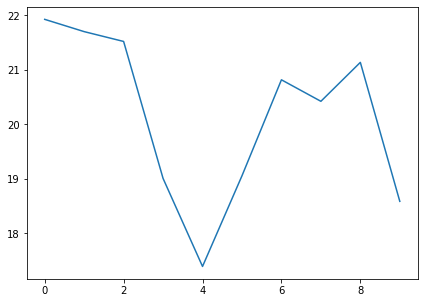

In [67]:
print('Difference between elegant and brute-force log posteriors for some random parameter values:')
print('(The third column should be basically constant, though non-zero.)\n')
diffs=[]
for i in range(10):
    a = np.random.rand() * 10.0 - 5.0
    b = np.random.rand() * 10.0 - 5.0
    diff = st.multivariate_normal.logpdf([a,b], mean=post_mean, cov=post_cov) - log_post_brute(a,b)
    diffs.append(diff)
    print([a, b, diff])
plt.plot(diffs)

#### Endnotes

##### Note 1

In statistics literature, a more common convention is $p(x|\mu,\sigma^2)$, with the second parameter being the variance rather than the standard deviation; this is then consistent with the multivariate Gaussian notation in which the second parameter is the covariance matrix. However, most code implementations of the univariate normal distribution take the standard deviation as an argument rather than the variance, so we'll stick with that notation.